In [197]:
# Mawrer Amed Ramirez Martinez
# Avance de TOG IDI 4
# ms723737@iteso.mx
# mawrer@gmail.com

import numpy as np
np.random.seed(1)
import tensorflow
tensorflow.random.set_seed(2)

from keras import backend as K
from keras import metrics
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation, Dense
from keras.layers.advanced_activations import LeakyReLU

from statsmodels.tsa.arima_model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf 

import pandas as pd 
import math as m
import os, glob

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [53]:
ID = "3"
MODEL_NAME = "LSTM"
NUM_FEATURES = "12"
TARGET_NAME = "Pct_Range_Close_diff"
MSE_RESULT = 0

In [14]:
RANGE = 1

HYPER_L1_IN = RANGE
EPOCHS = 100
BATCH_SIZE = 1

TEST_SIZE = .19
VAL_SIZE = .0

START_IN = 0

TRAINING_TIME_ELAPSED = 0

TRAIN_MSE=0
TRAIN_RMSE=0
TRAIN_MAE=0
TEST_MSE=0
TEST_RMSE=0
TEST_MAE=0


In [15]:
pwd = os.getcwd()
datasource_path = os.path.join(pwd, r'../../../Datasets/Junio2020/procesados/')
filenames = glob.glob(datasource_path + "/*.csv")
filenames.sort()
for file in filenames:
    print(os.path.basename(file))

DF_EURUSD_ASK_1H_PROC.csv


In [16]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
DATASET = pd.read_csv(filenames[0], header=0, parse_dates=['Gmt time'], date_parser=dateparse)
DATASET.head()


,Gmt time,Open,High,Low,Close,Volume,day_name,weekday,Pct_Range_Close,Pct_Range_Close_diff,MA_Close_5,MA_Close_25,MA_Close_50,MA_Close_200
0,2018-01-01 22:00:00,1.20143,1.20173,1.20062,1.20158,1623.5100,Monday,0,0.000000,0.000000,0.00000,0.0,0.0,0.0
1,2018-01-01 23:00:00,1.20158,1.20161,1.20044,1.20110,6297.2402,Monday,0,-0.000399,-0.000399,0.00000,0.0,0.0,0.0
2,2018-01-02 00:00:00,1.20109,1.20178,1.20096,1.20162,3564.4600,Tuesday,1,0.000433,0.000832,0.00000,0.0,0.0,0.0
3,2018-01-02 01:00:00,1.20162,1.20232,1.20141,1.20159,6219.6899,Tuesday,1,-0.000025,-0.000458,0.00000,0.0,0.0,0.0
4,2018-01-02 02:00:00,1.20157,1.20165,1.20081,1.20096,5386.5098,Tuesday,1,-0.000524,-0.000499,1.20137,0.0,0.0,0.0


In [17]:
#Describe DATASET
print('Shape: ', DATASET.shape)
print(DATASET.describe())
DATASET = DATASET.drop(['day_name'], axis = 1)
DATASET = DATASET.drop(['Gmt time'], axis = 1)
print(DATASET.dtypes)


Shape:  (15023, 14)
               Open          High           Low         Close         Volume  \
count  15023.000000  15023.000000  15023.000000  15023.000000   15023.000000   
mean       1.141308      1.141974      1.140634      1.141303   10819.459016   
std        0.043208      0.043281      0.043139      0.043206    8543.286582   
min        1.065520      1.066840      1.063640      1.065500       1.050000   
25%        1.109760      1.110295      1.109205      1.109760    5099.780000   
50%        1.131230      1.131880      1.130610      1.131210    9308.469700   
75%        1.163455      1.164190      1.162600      1.163420   14606.439950   
max        1.254930      1.255560      1.254370      1.254930  278504.156300   

            weekday  Pct_Range_Close  Pct_Range_Close_diff    MA_Close_5  \
count  15023.000000     15023.000000          1.502300e+04  15023.000000   
mean       2.050057        -0.000005         -1.078057e-08      1.140995   
std        1.506042         0.0

In [18]:
DF_Full = DATASET[199:]
DF_Full.reset_index(drop=True, inplace=True)
print(DF_Full.shape)
print(DF_Full.head())

(14824, 12)
      Open     High      Low    Close      Volume  weekday  Pct_Range_Close  \
0  1.20538  1.20574  1.20402  1.20443   5914.2402        4        -0.000788   
1  1.20443  1.20524  1.20426  1.20485   6369.0498        4         0.000349   
2  1.20484  1.20756  1.20458  1.20627  14090.5400        4         0.001179   
3  1.20630  1.21208  1.20525  1.21114  18746.5391        4         0.004037   
4  1.21115  1.21370  1.21111  1.21255  18016.5898        4         0.001164   

   Pct_Range_Close_diff  MA_Close_5  MA_Close_25  MA_Close_50  MA_Close_200  
0             -0.000962    1.204850     1.201357     1.198699      1.200896  
1              0.001137    1.204908     1.201740     1.198924      1.200912  
2              0.000830    1.205220     1.202222     1.199193      1.200938  
3              0.002859    1.206414     1.202907     1.199557      1.200986  
4             -0.002873    1.207848     1.203656     1.199938      1.201041  


In [19]:
total = DF_Full.shape[0]
print('Total: ', total)
print('Start: ', START_IN)

Total:  14824
Start:  0


In [20]:
#Shape the first START of the total
DF_Full = DF_Full.iloc[START_IN:]
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc
print(DF_Full.shape)

(14824, 12)


In [21]:

total = DF_Full.shape[0]
print('Total: ', total)

Total:  14824


In [22]:
#generate the VECTOR Y
close_y = DF_Full[TARGET_NAME].iloc[1:]
close_y.columns = [TARGET_NAME+'_y']
print(close_y.head())
print(close_y.shape)
close_y = close_y.append(close_y.tail(1), ignore_index=True)
print(close_y.tail())
print(close_y.shape)


1    0.001137
2    0.000830
3    0.002859
4   -0.002873
5   -0.001700
Name: Pct_Range_Close_diff, dtype: float64
(14823,)
14819    0.000649
14820   -0.000027
14821   -0.000792
14822    0.000000
14823    0.000000
Name: Pct_Range_Close_diff, dtype: float64
(14824,)


In [23]:
s1 = TEST_SIZE + VAL_SIZE
print('Sum of %s:',s1)
f1 = int(total * s1)
print('count of Val and Test:',f1)
end_train = total - f1
print('end of train: ', end_train)

count_val= int(total * VAL_SIZE)
print('count val: ',count_val)

count_test= int(total * TEST_SIZE)
print('count test: ',count_test)


end_val = end_train + count_val
print('end_val', end_val)



Sum of %s: 0.19
count of Val and Test: 2816
end of train:  12008
count val:  0
count test:  2816
end_val 12008


In [24]:
data_training = DF_Full.iloc[:end_train]
data_val = DF_Full.iloc[end_train: end_val]
data_test = DF_Full.iloc[end_val:]

print(data_training.shape)
print(data_val.shape)
print(data_test.shape)

data_training_y = close_y.iloc[:end_train]
data_val_y = close_y.iloc[end_train: end_val]
data_test_y = close_y.iloc[end_val:]

print(data_training_y.shape)
print(data_val_y.shape)
print(data_test_y.shape)

(12008, 12)
(0, 12)
(2816, 12)
(12008,)
(0,)
(2816,)


In [87]:
# DATA SET SCALER TRAINING
scaler = MinMaxScaler(feature_range=(-1, 1))
#print(data_training.head)
data_training_array = np.array(data_training)
data_training_array_scaled = scaler.fit_transform(data_training_array)
print(data_training_array_scaled)
    

[[ 0.40616012  0.4017053   0.39497717 ...  0.38781022  0.36994369
   0.43309826]
 [ 0.39477469  0.39570073  0.39786109 ...  0.39256677  0.37280435
   0.43331847]
 [ 0.3996884   0.42356191  0.40170632 ...  0.39854473  0.37622798
   0.43366664]
 ...
 [-0.68995686 -0.69833073 -0.69334295 ... -0.69783994 -0.69827532
  -0.78493916]
 [-0.69403164 -0.70169329 -0.69346311 ... -0.69719944 -0.69946493
  -0.78452365]
 [-0.69223394 -0.69929146 -0.69045902 ... -0.69652419 -0.70058831
  -0.78411016]]


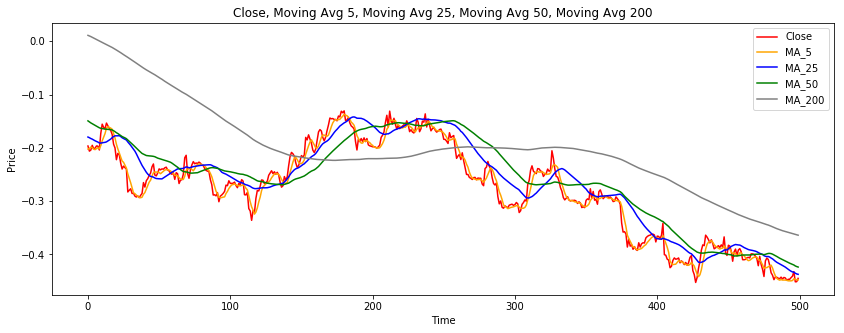

In [88]:
INICIO = 4500
FIN = 5000
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,3], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,8], color = 'orange', label = 'MA_5')
pyplot.plot(data_training_array_scaled[INICIO:FIN,9], color = 'blue', label = 'MA_25')
pyplot.plot(data_training_array_scaled[INICIO:FIN,10], color = 'green', label = 'MA_50')
pyplot.plot(data_training_array_scaled[INICIO:FIN,11], color = 'gray', label = 'MA_200')
plt.title('Close, Moving Avg 5, Moving Avg 25, Moving Avg 50, Moving Avg 200')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(12008, 12)


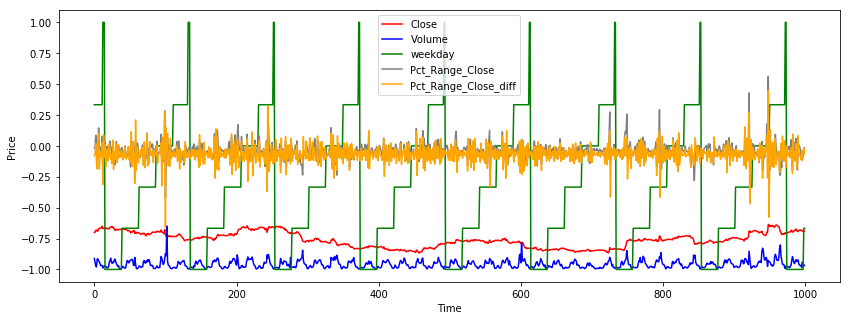

In [89]:
print(data_training_array_scaled.shape)
INICIO = 11008
FIN = 12008
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,3], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,4], color = 'blue', label = 'Volume')
pyplot.plot(data_training_array_scaled[INICIO:FIN,5], color = 'green', label = 'weekday')
pyplot.plot(data_training_array_scaled[INICIO:FIN,6], color = 'gray', label = 'Pct_Range_Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,7], color = 'orange', label = 'Pct_Range_Close_diff')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(12008, 12)


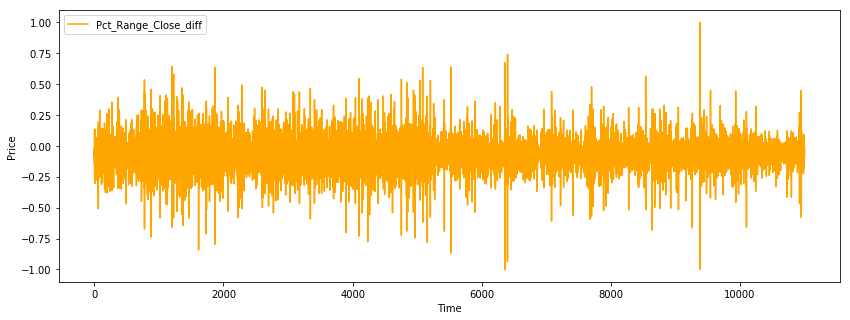

In [90]:
print(data_training_array_scaled.shape)
INICIO = 1008
FIN = 12008
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,7], color = 'orange', label = 'Pct_Range_Close_diff')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

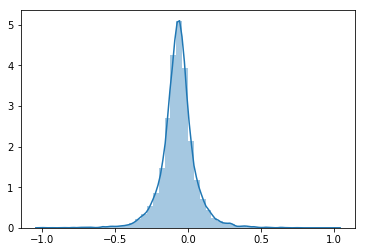

In [91]:
sns.distplot(data_training_array_scaled[INICIO:FIN,7]);

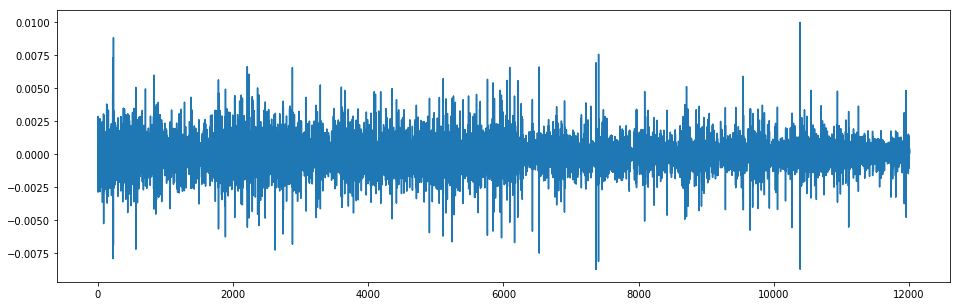

In [92]:
pyplot.figure(figsize=(16,5))
pyplot.plot(data_training_y)

In [93]:
X_train = []
y_train = []
for i in range(RANGE, data_training_array_scaled.shape[0]):
    X_train.append(data_training_array_scaled[i-RANGE:i])
    y_train.append(data_training_y[i])

X_train_np, y_train_np = np.array(X_train), np.array(y_train)

print(X_train_np.shape)
print(y_train_np.shape)

(12007, 1, 12)
(12007,)


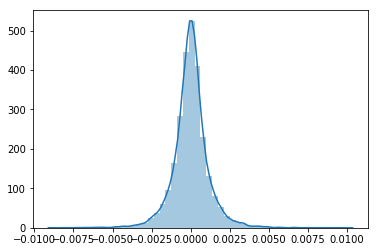

In [94]:
sns.distplot(y_train_np);



In [95]:

#Obtener los ultimos valores de Train para agregarlos a Val DF
# APPEND DE X
last_range_training_x = data_training.tail(RANGE)
print(last_range_training_x.shape)
print(data_val.shape)
data_val_x1 = last_range_training_x.append(data_val, ignore_index = True)
data_val_x1.shape
print(data_val_x1.head)

(1, 12)
(0, 12)
<bound method NDFrame.head of       Open     High      Low    Close     Volume  weekday  Pct_Range_Close  \
0  1.11373  1.11406  1.11369  1.11394  4306.9702        1         0.000189   

   Pct_Range_Close_diff  MA_Close_5  MA_Close_25  MA_Close_50  MA_Close_200  
0              0.000045    1.113924        1.114     1.114648      1.110523  >


In [96]:
#Append de los datos de Train al DF de Val en Y
last_range_train_y = data_training_y.tail(RANGE)
print(last_range_train_y.shape)
print(data_val_y.shape)
data_val_y1 = last_range_train_y.append(data_val_y, ignore_index = True)
data_val_y1.shape
print(data_val_y1.head(10))

(1,)
(0,)
0    0.00026
Name: Pct_Range_Close_diff, dtype: float64


In [97]:
data_val_x2 = scaler.transform(data_val_x1)
data_val_x2.shape
print(data_val_x2[:10])

[[-0.69223394 -0.69929146 -0.69045902 -0.68971716 -0.96594966 -0.66666667
  -0.01661245 -0.06190772 -0.69552405 -0.69652419 -0.70058831 -0.78411016]]


In [98]:
X_val = []
y_val = []
for i in range(RANGE, data_val_x2.shape[0]):
    X_val.append(data_val_x2[i-RANGE:i])
    y_val.append(data_val_y1[i])

X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
print(X_val_np.shape)
print(y_val_np.shape)

(0,)
(0,)


In [99]:

#Obtener los ultimos valores de Val para agregarlos a TEST DF
# Append en X
last_range_data_training_x = data_training.tail(RANGE)
print(last_range_data_training_x.shape)
print(data_test.shape)
data_test_x1 = last_range_data_training_x.append(data_test, ignore_index = True)
data_test_x1.shape


(1, 12)
(2816, 12)


(2817, 12)

In [100]:
#Append de los datos de Val al DF de Test de Y
last_range_training_y = data_training_y.tail(RANGE)
print(last_range_training_y.shape)
print(data_test_y.shape)
data_test_y1 = last_range_training_y.append(data_test_y, ignore_index = True)
data_test_y1.shape

(1,)
(2816,)


(2817,)

In [101]:
data_test_x2 = scaler.transform(data_test_x1)
data_test_x2.shape
print(data_test_x2[:10])

[[-0.69223394 -0.69929146 -0.69045902 -0.68971716 -0.96594966 -0.66666667
  -0.01661245 -0.06190772 -0.69552405 -0.69652419 -0.70058831 -0.78411016]
 [-0.68971716 -0.69412754 -0.6875751  -0.68372483 -0.98027556 -0.66666667
   0.01655456 -0.03886495 -0.69557236 -0.69571985 -0.70123788 -0.78363   ]
 [-0.68372483 -0.69040471 -0.68144677 -0.68060882 -0.9780908  -0.66666667
  -0.01091109 -0.08976398 -0.69368825 -0.69485096 -0.70200208 -0.78314311]
 [-0.68048897 -0.68872343 -0.68024513 -0.67988974 -0.98163236 -0.66666667
  -0.03377935 -0.08590463 -0.69081379 -0.69411116 -0.70267203 -0.78268517]
 [-0.68012943 -0.68860334 -0.67868301 -0.67988974 -0.97749642 -0.66666667
  -0.04063775 -0.0724649  -0.6883258  -0.69338626 -0.70344388 -0.78221983]
 [-0.68000959 -0.69004443 -0.68445085 -0.68168744 -0.96977476 -0.66666667
  -0.05778282 -0.08110021 -0.68670741 -0.6928401  -0.70408326 -0.78176661]
 [-0.68156759 -0.69208599 -0.68637347 -0.68600192 -0.95067589 -0.66666667
  -0.08179146 -0.08686194 -0.687

In [102]:
X_test = []
y_test = []
for i in range(RANGE, data_test_x2.shape[0]):
    X_test.append(data_test_x2[i-RANGE:i])
    y_test.append(data_test_y1[i])

X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
print(X_test_np.shape)
print(y_test_np.shape)

(2816, 1, 12)
(2816,)


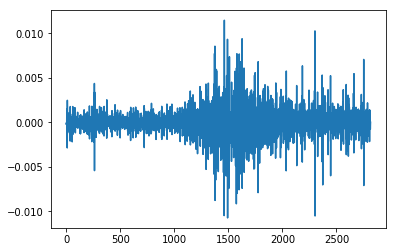

In [103]:
# Y del dataset de pruebas
pyplot.plot(y_test_np)

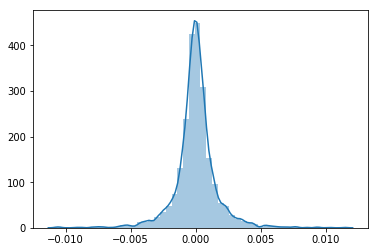

In [104]:
sns.distplot(y_test_np);


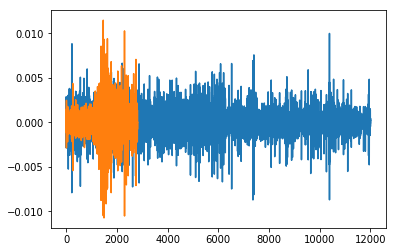

In [105]:

# Y de Val y Test comparados
pyplot.plot(y_train_np)
pyplot.plot(y_test_np)
pyplot.plot(y_val_np)


In [106]:
x_shape = X_train_np.shape[1]
print(x_shape)
y_shape = X_train_np.shape[2]
print(y_shape)

1
12


In [200]:
# NEW MODEL
model = Sequential()
#gru = tf.keras.layers.GRU(4)
#tf.keras.layers.
model.add(tf.keras.layers.GRU(50, input_shape=(x_shape, y_shape), return_sequences=True))
model.add(tf.keras.layers.GRU(50, return_sequences=True))
model.add(tf.keras.layers.GRU(10, return_sequences=True))
#model.add(Dropout(0.2))
model.add(tf.keras.layers.GRU(4, return_sequences=False))
model.add(Dense(4, kernel_initializer='uniform', activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
model.add(Dense(1, kernel_initializer='uniform', activation=tf.keras.layers.LeakyReLU(alpha=0.01)))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 1, 50)             9600      
_________________________________________________________________
gru_9 (GRU)                  (None, 1, 50)             15300     
_________________________________________________________________
gru_10 (GRU)                 (None, 1, 10)             1860      
_________________________________________________________________
gru_11 (GRU)                 (None, 4)                 192       
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 5         
Total params: 26,977
Trainable params: 26,977
Non-trainable params: 0
_________________________________________________

In [161]:
regressior = Sequential()

regressior.add(LSTM(units = RANGE, activation = 'tanh', return_sequences = True, input_shape = (x_shape, y_shape)))
#regressior.add(Dropout(0.2))

regressior.add(LSTM(units = 60, activation = 'tanh', return_sequences = True))
#regressior.add(Dropout(0.2))

#regressior.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))

regressior.add(LSTM(units = 60, activation = 'tanh'))
#regressior.add(Dropout(0.2))

regressior.add(Dense(units = 1))


In [162]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [163]:
regressior.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])

In [164]:
regressior.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 1, 1)              56        
_________________________________________________________________
lstm_17 (LSTM)               (None, 1, 60)             14880     
_________________________________________________________________
lstm_18 (LSTM)               (None, 60)                29040     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 61        
Total params: 44,037
Trainable params: 44,037
Non-trainable params: 0
_________________________________________________________________


In [165]:
pwd = os.getcwd()
source_data = os.path.join(pwd, r'../../../Models/2020/LSTM/')
print(source_data)

C:\Users\maw\Documents\GitHub\forex_prediction\Jupyter Notebooks\IDI4\models\../../../Models/2020/LSTM/


In [166]:
#Model check pointer para almacenar el modelo cada epoca
checkpointer = ModelCheckpoint(filepath=source_data + '/model-{epoch:02d}.hdf5', verbose=1)

In [201]:
#%%time
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpointer])
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np))
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np), callbacks=[checkpointer], shuffle=True)
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np))
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)

history = model.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)





Train on 12007 samples
Epoch 1/100
12007/12007 [==============================] - 10s 803us/sample - loss: 1.3589e-06 - mae: 7.9759e-04 - mse: 1.3589e-06
Epoch 2/100
12007/12007 [==============================] - 3s 259us/sample - loss: 1.3537e-06 - mae: 7.9485e-04 - mse: 1.3537e-06
Epoch 3/100
12007/12007 [==============================] - 3s 256us/sample - loss: 1.3537e-06 - mae: 7.9505e-04 - mse: 1.3537e-06
Epoch 4/100
12007/12007 [==============================] - 3s 260us/sample - loss: 1.3540e-06 - mae: 7.9491e-04 - mse: 1.3540e-06
Epoch 5/100
12007/12007 [==============================] - 3s 256us/sample - loss: 1.3534e-06 - mae: 7.9467e-04 - mse: 1.3534e-06
Epoch 6/100
12007/12007 [==============================] - 3s 272us/sample - loss: 1.3548e-06 - mae: 7.9568e-04 - mse: 1.3548e-06
Epoch 7/100
12007/12007 [==============================] - 3s 277us/sample - loss: 1.3625e-06 - mae: 7.9951e-04 - mse: 1.3625e-06
Epoch 8/100
12007/12007 [==============================] - 3s 274u

12007/12007 [==============================] - 3s 261us/sample - loss: 1.3538e-06 - mae: 7.9548e-04 - mse: 1.3538e-06
Epoch 64/100
12007/12007 [==============================] - 3s 267us/sample - loss: 1.3585e-06 - mae: 7.9717e-04 - mse: 1.3585e-06
Epoch 65/100
12007/12007 [==============================] - 3s 266us/sample - loss: 1.3621e-06 - mae: 7.9978e-04 - mse: 1.3621e-06
Epoch 66/100
12007/12007 [==============================] - 3s 268us/sample - loss: 1.3628e-06 - mae: 8.0080e-04 - mse: 1.3628e-06
Epoch 67/100
12007/12007 [==============================] - 3s 266us/sample - loss: 1.3572e-06 - mae: 7.9698e-04 - mse: 1.3572e-06
Epoch 68/100
12007/12007 [==============================] - 3s 257us/sample - loss: 1.3577e-06 - mae: 7.9750e-04 - mse: 1.3577e-06
Epoch 69/100
12007/12007 [==============================] - 3s 260us/sample - loss: 1.3554e-06 - mae: 7.9553e-04 - mse: 1.3554e-06
Epoch 70/100
12007/12007 [==============================] - 3s 260us/sample - loss: 1.3536e-06 -

In [168]:
file_name = MODEL_NAME + '_' + NUM_FEATURES + '_' + TARGET_NAME + "_"+ ID + '.hdf5'
print(file_name)
regressior.save(source_data + file_name)


LSTM_12_Pct_Range_Close_diff_3.hdf5


In [181]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'mse'])


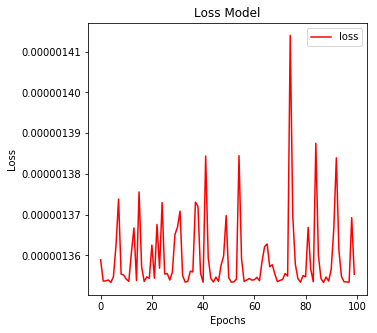

In [202]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
#plt.plot(history.history['val_loss'][1:], color = 'blue', label = 'Val_Loss')
plt.plot(history.history['loss'], color = 'red', label = 'loss')
#plt.plot(history.history['mean_absolute_error'][1:], color = 'blue', label = 'MAE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

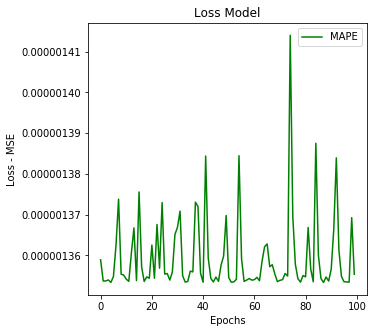

In [203]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
plt.plot(history.history['mse'][:], color = 'green', label = 'MAPE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss - MSE')
plt.legend()
plt.show()


In [172]:
#Load Model
filepath = os.path.join(source_data, file_name)
#filepath = os.path.join(source_data, r'final_model.hdf5')
print(filepath)
model = tf.keras.models.load_model(filepath)

C:\Users\maw\Documents\GitHub\forex_prediction\Jupyter Notebooks\IDI4\models\../../../Models/2020/LSTM/LSTM_12_Pct_Range_Close_diff_3.hdf5


In [204]:
y_test_pred = model.predict(X_test_np)
y_test_pred.shape



(2816, 1)

In [205]:
y_train_pred = model.predict(X_train_np)
y_train_pred.shape


(12007, 1)

(2816,)
(2816, 1)


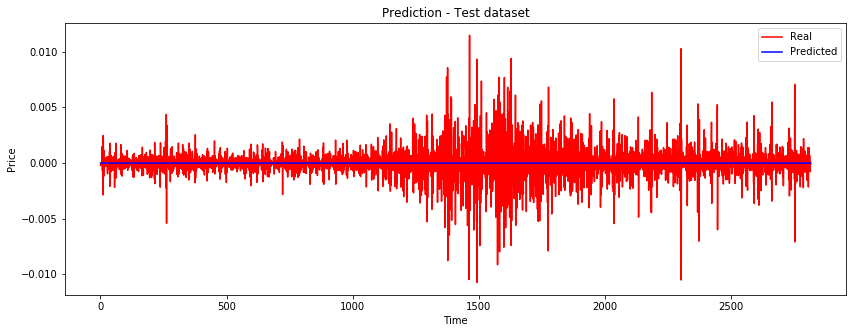

In [207]:
INICIO = 0
FIN = 2816
print(y_test_np.shape)
print(y_test_pred.shape)
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test_np[INICIO:FIN], color = 'red', label = 'Real')
plt.plot(y_test_pred[INICIO:FIN], color = 'blue', label = 'Predicted')
plt.title('Prediction - Test dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [208]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [209]:
print('Test MAE:', mean_absolute_error(y_test_np, y_test_pred))#Mean Absolute Error
print('Test RMSE:',np.sqrt(mean_squared_error(y_test_np, y_test_pred)))#Root Mean Squared Error
print('Test MSE:',mean_squared_error(y_test_np, y_test_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_test_np, y_test_pred))#Mean Absolute Percentaje Error


Test MAE: 0.0010341396937062549
Test RMSE: 0.0016303832509508074
Test MSE: 2.6581495449809236e-06
Test MAPE: inf


(12007,)


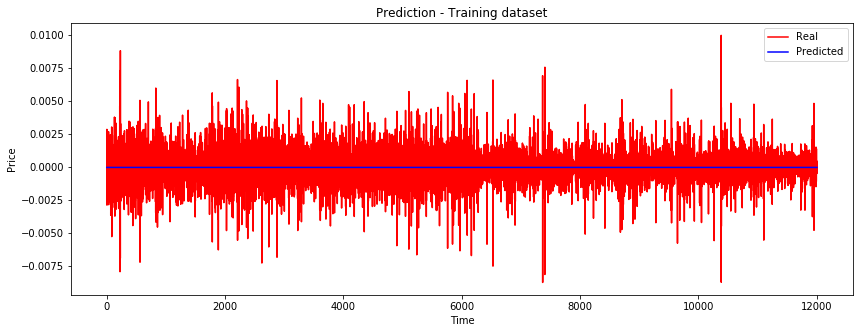

In [216]:
print(y_train_np.shape)
INICIO = 0
FIN = 12007
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_train_np[INICIO:FIN], color = 'red', label = 'Real')
plt.plot(y_train_pred[INICIO:FIN], color = 'blue', label = 'Predicted')
plt.title('Prediction - Training dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
print('Train MAE:', mean_absolute_error(y_train_np, y_train_pred))#Mean Absolute Error
print('Train RMSE:',np.sqrt(mean_squared_error(ycc_train_np, y_train_pred)))#Root Mean Squared Error
print('Train MSE:',mean_squared_error(y_train_np, y_train_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_train_np, y_train_pred))#Mean Absolute Percentaje Error
